<a href="https://colab.research.google.com/github/Developer-Gilbert/Practice-project/blob/main/0_3_%EC%A0%84%EC%9D%B4_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 에일리언 vs 프레데터 데이터셋**
- https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
- 로그인 ->

{"username":"gichul","key":"c3aea7cdd37b792f5621d2379c6ff629"}

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'gichul'
os.environ['KAGGLE_KEY'] = 'c3aea7cdd37b792f5621d2379c6ff629'

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q alien-vs-predator-images.zip

replace alien_vs_predator_thumbnails/data/train/alien/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
device='cuda' if torch.cuda.is_available()else 'cpu'
print(device)

cuda


# **2. 이미지 증강 기법(Image Augmentation)**
- 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를
가진 이미지를 생성
  - 모델 성능이 좋아짐
  - 오버피팅을 방지
  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
data_transforms = {
    'train' : transforms.Compose([# Compose 함수는 리스트 안에 들어있는 함수들을 동시에 실행한다.
        transforms.Resize((224, 224)),

        # 기존 영상은 그대로 두고, 각도를 10도 돌리고, 크기도 80~120 까지 랜덤으로!
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),

        # 이미지를 수평으로 눕힌다.
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
      ]),
      'validation' : transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])
}

In [ ]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation' : datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [ ]:
dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle = True
    ),
    'validation' : DataLoader(
        image_datasets['validation'],
        batch_size = 32,
        shuffle = True
    )
}

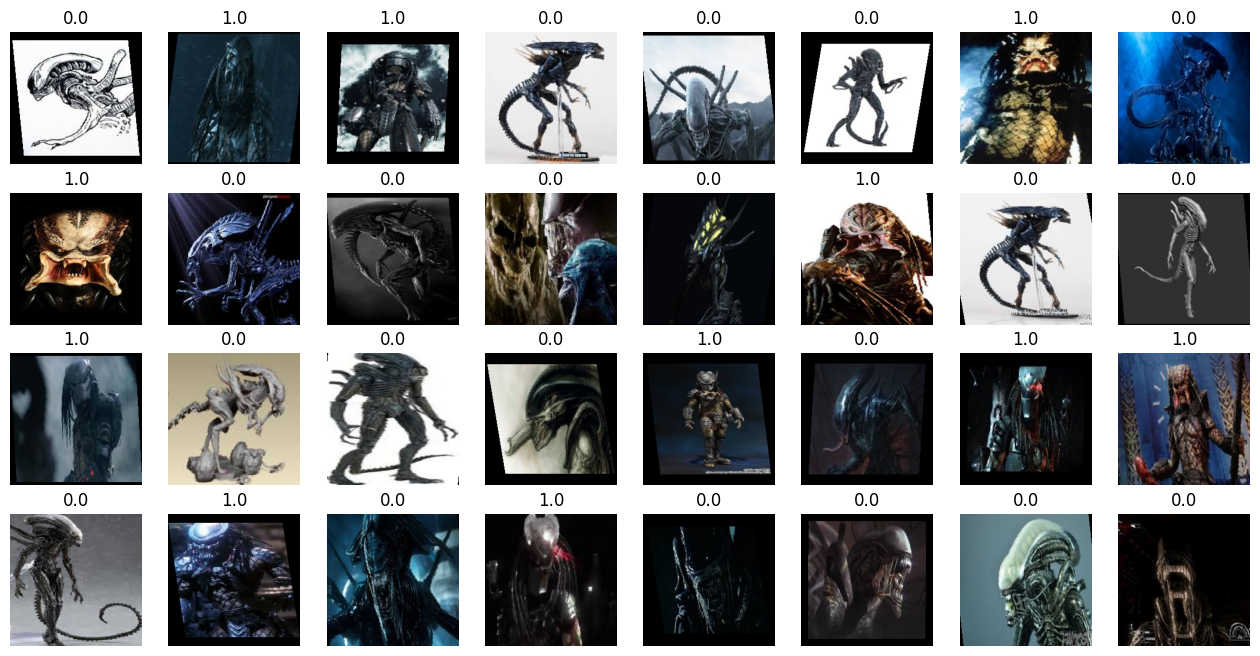

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize = (16, 8))

for axes, img, label in zip(axes.flatten(), imgs, labels):
  axes.imshow(img.permute(1, 2, 0))
  axes.set_title(label.item())
  axes.axis('off')

# **3. 전이 학습(Transfer Learning)**
- 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의
시작점으로 활용하는 딥러닝 접근법
- 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더빠르고 간편함
- 전이 학습은 여러 응용분야중에서 특히 검출, 영상인식, 음성 인식에 많이 사용

### 3-1 전이 학습의 고려할 점
- 크기 : 모델 크기는 배포할 위치와 방법에 따라 달라짐
- 예측 속도와 정확도 : 하드웨어 및 배치 크기와 같은 요소를 고려

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

# **4. 사전 학습된 ResNet50 모델**

![](https://i.stack.imgur.com/gI4zT.png)

### 4-1. 이미지넷(ImageNet)
- 이미지 데이터베이스
- 1000개의 동물과 사물 이미지를 포함

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4-2. Freeze Layers
- 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을
하지 않도록 설정
- 출력 부분의 레이어를 다시 설정하여 분류에 맞게 변경

In [ ]:
for param in model.parameters():        #웨이트값과 바이어스 값을 가져오는 애
  param.requires_grad = False


model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [ ]:
# 학습
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for item in ['train', 'validation']:
    if item == 'train':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[item]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if item == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses += loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs += acc.item()

    avg_loss = sum_losses / len(dataloaders[item])
    avg_acc = sum_accs / len(dataloaders[item])

    print(f'epo {epoch+1}   loss : {avg_loss : .4f}   acc : {avg_acc : .2f}%')

epo 1   loss :  0.5203   acc :  74.16%
epo 1   loss :  0.3732   acc :  86.61%
epo 2   loss :  0.3244   acc :  87.38%
epo 2   loss :  0.3701   acc :  82.14%
epo 3   loss :  0.2878   acc :  88.51%
epo 3   loss :  0.2708   acc :  89.29%
epo 4   loss :  0.2009   acc :  92.42%
epo 4   loss :  0.2269   acc :  92.41%
epo 5   loss :  0.1804   acc :  93.18%
epo 5   loss :  0.1968   acc :  92.41%
epo 6   loss :  0.1571   acc :  94.18%
epo 6   loss :  0.2336   acc :  91.52%
epo 7   loss :  0.1953   acc :  90.92%
epo 7   loss :  0.2242   acc :  89.29%
epo 8   loss :  0.2086   acc :  91.27%
epo 8   loss :  0.1972   acc :  91.07%
epo 9   loss :  0.1944   acc :  91.34%
epo 9   loss :  0.2431   acc :  89.73%
epo 10   loss :  0.2156   acc :  91.71%
epo 10   loss :  0.2570   acc :  90.18%


In [ ]:
from PIL import Image

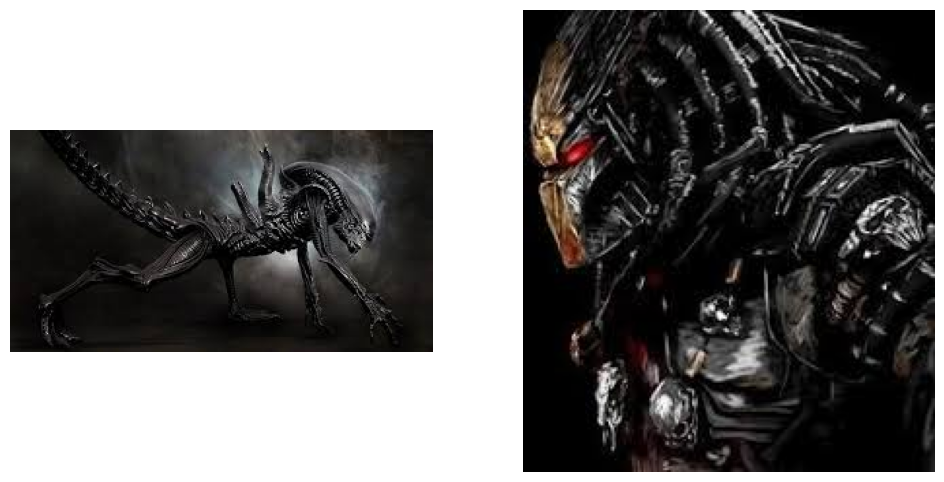

In [ ]:
img1 = Image.open('/content/data/validation/alien/49.jpg')
img2 = Image.open('/content/data/validation/predator/44.jpg')

fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes[0].imshow(img1)
axes[1].imshow(img2)
axes[0].axis('off')
axes[1].axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
# stack
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred = model(test_batch)
y_pred

tensor([[0.0016],
        [0.9939]], device='cuda:0', grad_fn=<SigmoidBackward0>)

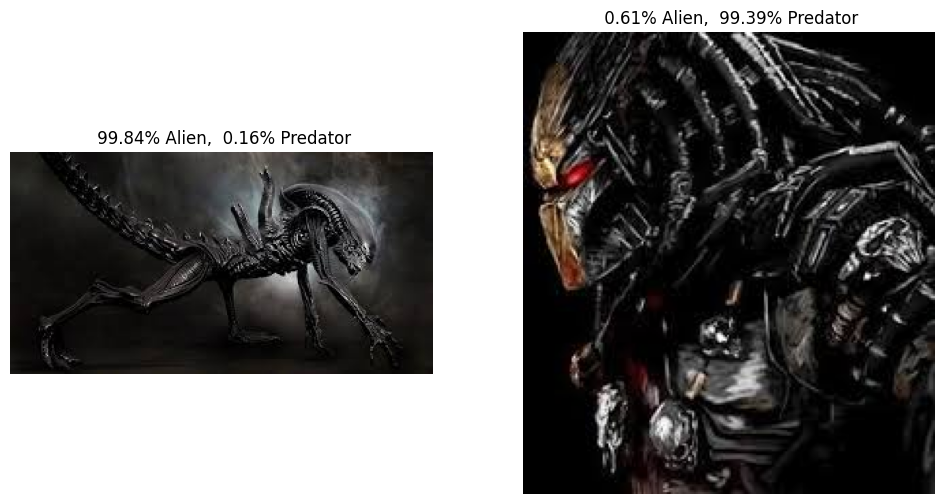

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

axes[0].set_title(f'{(1-y_pred[0, 0]) * 100 : .2f}% Alien, {y_pred[0, 0] * 100 : .2f}% Predator')
axes[0].imshow(img1)

axes[1].set_title(f'{(1-y_pred[1, 0]) * 100 : .2f}% Alien, {y_pred[1, 0] * 100 : .2f}% Predator')
axes[1].imshow(img2)

axes[0].axis('off')
axes[1].axis('off')
plt.show()